In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [9]:
data = pd.read_csv('country_vaccinations.csv')

In [10]:
data

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
1,Albania,ALB,2021-01-11,NaN,NaN,NaN,NaN,64.0,NaN,NaN,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
2,Albania,ALB,2021-01-12,128.0,128.0,NaN,NaN,64.0,0.00,0.00,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
3,Albania,ALB,2021-01-13,188.0,188.0,NaN,60.0,63.0,0.01,0.01,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
4,Albania,ALB,2021-01-14,266.0,266.0,NaN,78.0,66.0,0.01,0.01,NaN,23.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,Zimbabwe,ZWE,2021-02-22,1314.0,1314.0,NaN,NaN,328.0,0.01,0.01,NaN,22.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1365400469...
4376,Zimbabwe,ZWE,2021-02-23,4041.0,4041.0,NaN,2727.0,808.0,0.03,0.03,NaN,54.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1365400469...
4377,Zimbabwe,ZWE,2021-02-24,7872.0,7872.0,NaN,3831.0,1312.0,0.05,0.05,NaN,88.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1365400469...
4378,Zimbabwe,ZWE,2021-02-25,11007.0,11007.0,NaN,3135.0,1572.0,0.07,0.07,NaN,106.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1365400469...


In [11]:
data.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
1,Albania,ALB,2021-01-11,NaN,NaN,NaN,NaN,64.0,NaN,NaN,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
2,Albania,ALB,2021-01-12,128.0,128.0,NaN,NaN,64.0,0.00,0.00,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
3,Albania,ALB,2021-01-13,188.0,188.0,NaN,60.0,63.0,0.01,0.01,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
4,Albania,ALB,2021-01-14,266.0,266.0,NaN,78.0,66.0,0.01,0.01,NaN,23.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              4380 non-null   object 
 1   iso_code                             4080 non-null   object 
 2   date                                 4380 non-null   object 
 3   total_vaccinations                   2866 non-null   float64
 4   people_vaccinated                    2438 non-null   float64
 5   people_fully_vaccinated              1626 non-null   float64
 6   daily_vaccinations_raw               2421 non-null   float64
 7   daily_vaccinations                   4226 non-null   float64
 8   total_vaccinations_per_hundred       2866 non-null   float64
 9   people_vaccinated_per_hundred        2438 non-null   float64
 10  people_fully_vaccinated_per_hundred  1626 non-null   float64
 11  daily_vaccinations_per_million

In [13]:
data["source_website"].value_counts() # Just wondering where the data comes from

https://coronavirus.data.gov.uk/details/healthcare                                                   375
https://ls-osp-sdg.maps.arcgis.com/apps/opsdashboard/index.html#/b7063ad3f8c149d394be7f043dfce460     81
https://datadashboard.health.gov.il/COVID-19/general                                                  70
https://covid.cdc.gov/covid-data-tracker/#vaccinations                                                69
https://twitter.com/MOH_Bahrain/status/1365406359714414597                                            66
                                                                                                    ... 
https://twitter.com/MinisteredelaS1/status/1365243122909913094/photo/2                                 4
https://vaccination.covid19.gov.ua/                                                                    3
http://ncv.kdca.go.kr/                                                                                 2
https://sermitsiaq.ag/ikke-flere-vacciner-nuuk         

In [14]:
data.describe()

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
count,2.866000e+03,2.438000e+03,1.626000e+03,2.421000e+03,4.226000e+03,2866.000000,2438.000000,1626.000000,4226.000000
mean,1.671404e+06,1.449764e+06,4.734866e+05,7.424104e+04,5.487989e+04,6.953692,5.667063,2.216052,2393.753195
std,5.640491e+06,4.556002e+06,1.828830e+06,2.072850e+05,1.734581e+05,12.932168,9.320872,5.404122,4380.248455
min,0.000000e+00,0.000000e+00,1.000000e+00,-5.001200e+04,1.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3.089200e+04,2.773250e+04,1.054350e+04,2.224000e+03,1.121000e+03,0.602500,0.582500,0.202500,321.000000
50%,2.009375e+05,1.797725e+05,4.979950e+04,1.177300e+04,5.745000e+03,2.690000,2.520000,0.825000,1056.500000
75%,8.361038e+05,7.143455e+05,2.498918e+05,5.308900e+04,2.667850e+04,6.570000,5.140000,1.877500,2162.500000
max,7.045406e+07,4.718420e+07,2.261336e+07,2.242472e+06,1.916190e+06,102.700000,64.090000,38.610000,54264.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6d2c0e210>,
      dtype=object)

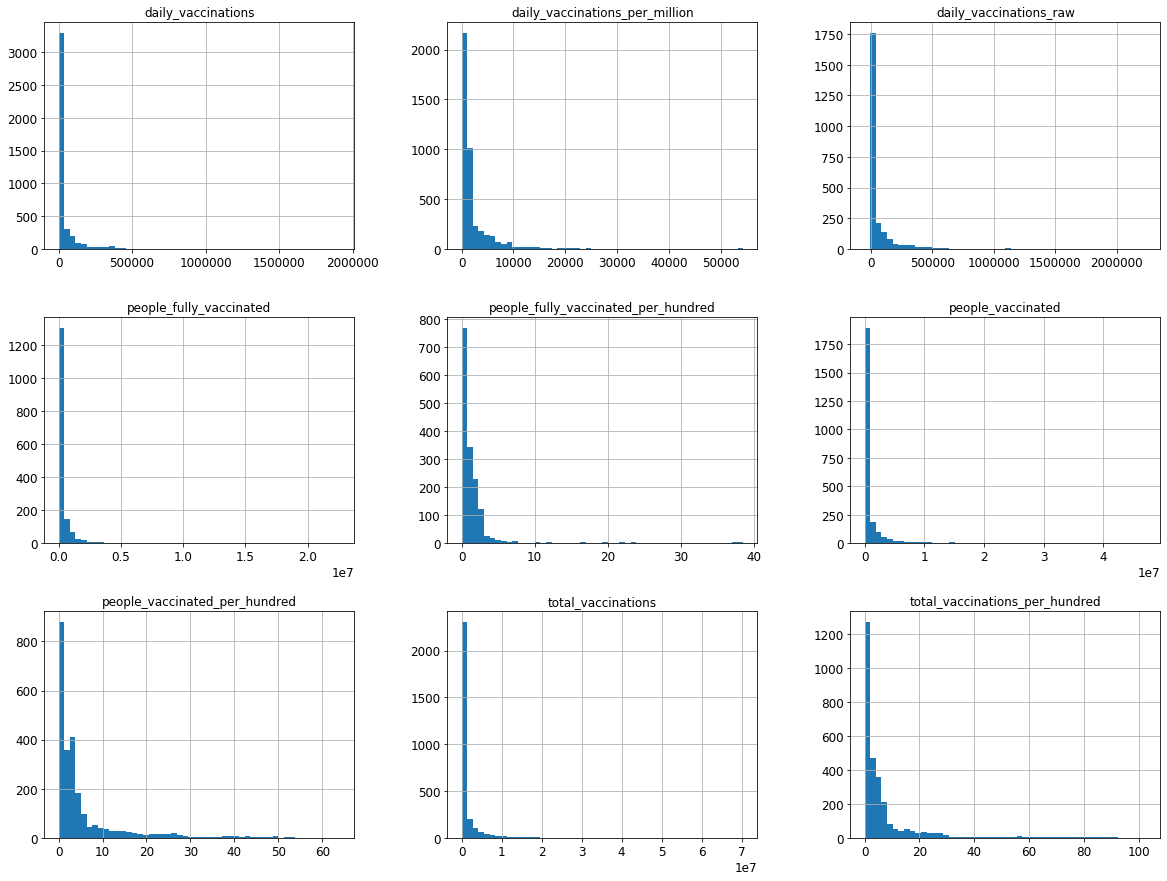

In [20]:
data.hist(bins=50, figsize=(20, 15))

In [23]:
# We see most countries have not begun much vaccination

# We also see that all graphs essentially show the same relationship of exponential

In [24]:
# format date into a date data type

data["date"] = pd.to_datetime(data["date"], format='%Y-%m-%d')

In [25]:
# getting rid of NaN's

data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6d4de3f50>,
      dtype=object)

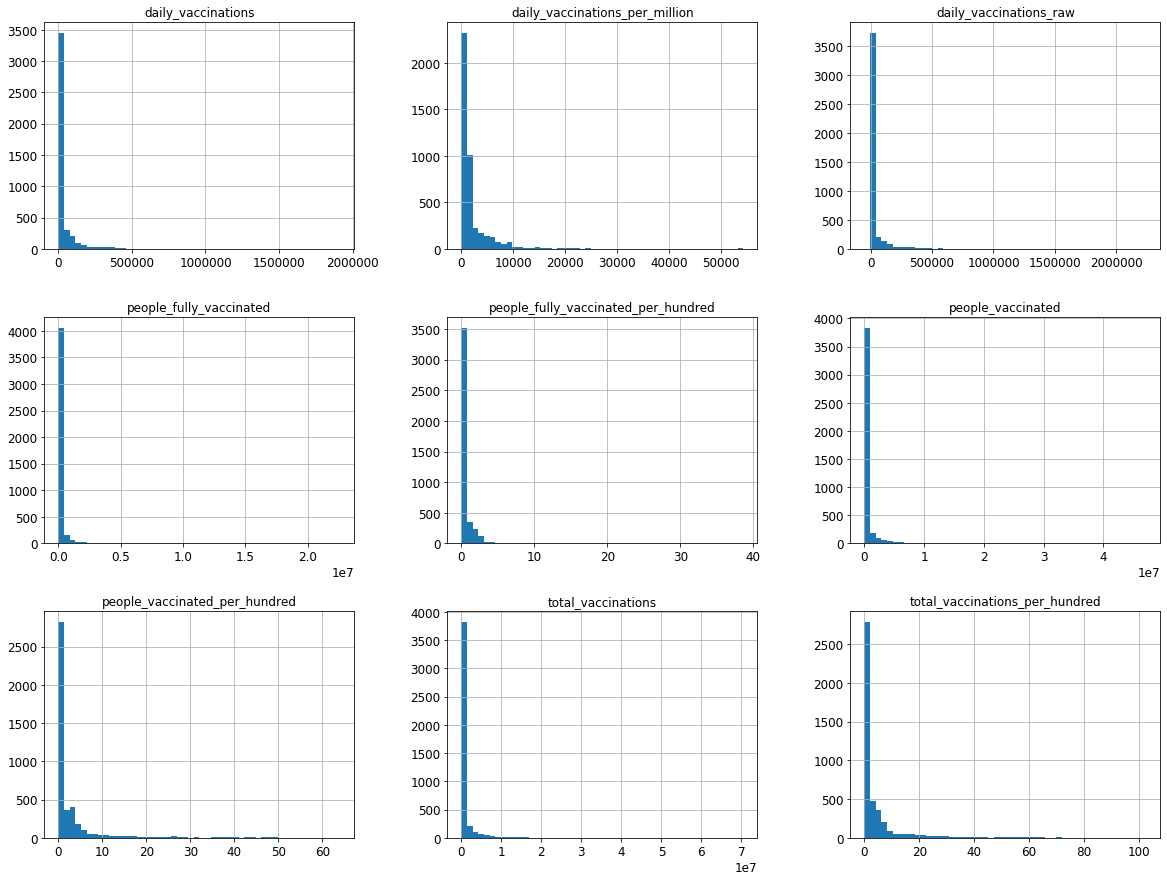

In [26]:
data.hist(bins=50, figsize=(20,15))

In [ ]:
# as expected there are much more zeros which makes all relationships look more simil